In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from dateutil import parser

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Exploratory Climate Analysis

In [11]:
max_date_in_data = session.query(func.max(Measurement.date)).scalar()
max_date = parser.parse(max_date_in_data)
max_date

datetime.datetime(2017, 8, 23, 0, 0)

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores
current_time = datetime.utcnow()
climate1 = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > max_date - timedelta(weeks=52) ).\
    order_by(Measurement.date).\
    all()

df = pd.DataFrame(climate1, columns=['date', 'prcp'])
df = df.rename(columns = {'prcp':'precipitation'})
df.head(10)

,date,precipitation
0,2016-08-25,0.08
1,2016-08-25,0.08
2,2016-08-25,0.00
3,2016-08-25,0.00
4,2016-08-25,0.21
5,2016-08-25,0.06
6,2016-08-25,0.11
7,2016-08-26,0.00
8,2016-08-26,0.03
9,2016-08-26,0.02


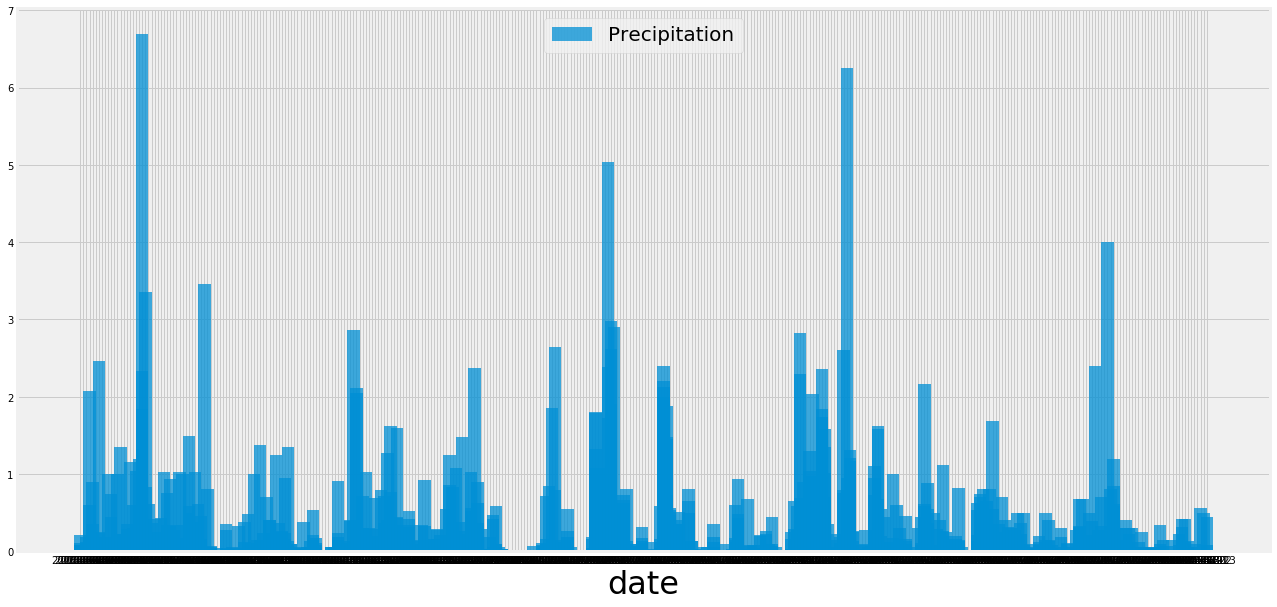

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
# ax = df.plot.bar(x='date', y='prcp', rot=0) 
# plt.bar

x = df['date']
y = df['precipitation']
fig = plt.figure(figsize=(20,10))
#ax1 = fig.add_subplot()
plt.bar(x, y, width = 4, alpha=0.75,)
plt.xlabel('date', fontsize = 32)
#ax.set_ylim((0, 7)) 
plt.legend(["Precipitation"],loc="upper center", fontsize = 20)
#plt.axis([0, 1, 2, 3, 4, 5, 6, 7])
#plt.yticks(size = 30)
#df.plot()
plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data

In [15]:
df.describe()

,precipitation
count,2009.000000
mean,0.172344
std,0.452818
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).count()

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_count = session.query(Measurement.station, func.count(Measurement.station).\
         label('station_count')).\
         group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).\
        all()

station_count                  

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
active_station = station_count[0][0]
active_station
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == active_station).all()

[(54.0, 85.0, 71.66378066378067)]

Text(0,0.5,'Frequency')

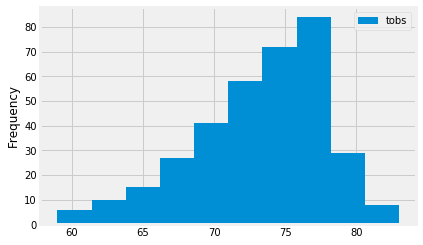

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > max_date - timedelta(weeks=52) ).\
    filter(Measurement.station == active_station).\
    order_by(Measurement.date).\
    all()

active_station_df = pd.DataFrame(active_station_data, columns=['date', 'tobs'])

station_plot = active_station_df.plot(y="tobs",kind="hist")
station_plot.set_ylabel("Frequency")

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-02-28', '2017-03-05'))

[(64.0, 72.02777777777777, 78.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps('2017-02-28', '2017-03-05')
print(temps)

[(64.0, 72.02777777777777, 78.0)]


In [22]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)) .\
        join(Measurement, Measurement.station == Station.station ) .\
        filter(Measurement.date >= '2017-02-28').filter(Measurement.date <= '2017-03-05').\
        group_by(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation) .\
        order_by(func.sum(Measurement.prcp).desc()) .\
        all()

[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  4.720000000000001),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 4.45),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  4.07),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 2.98),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  2.7399999999999998),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.32),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.1600000000000001)]

## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
normals = []
normals.append(daily_normals("02-28")[0])
normals.append(daily_normals("03-01")[0])
normals.append(daily_normals("03-02")[0])
normals.append(daily_normals("03-03")[0])
normals.append(daily_normals("03-04")[0])
normals.append(daily_normals("03-05")[0])
normals

[(65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df = df.set_index([pd.Index(['2018-02-28', '2018-03-01', '2018-03-02', '2018-03-03', '2018-03-04', '2018-03-05'], name='date')])
df.reset_index(inplace=True)
df

,date,tmin,tavg,tmax
0,2018-02-28,65.0,70.655172,80.0
1,2018-03-01,64.0,70.032787,76.0
2,2018-03-02,61.0,70.366667,78.0
3,2018-03-03,60.0,70.068966,78.0
4,2018-03-04,57.0,69.272727,77.0
5,2018-03-05,60.0,67.890909,76.0


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 <a list of 8 Text xticklabel objects>)

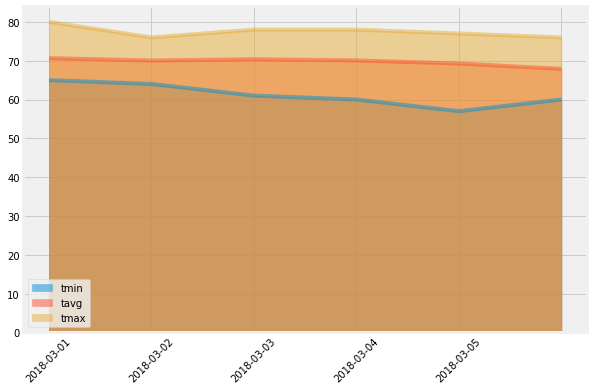

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
#df.set_index('date', inplace=True)
ax = df.plot(kind="area", stacked=False, figsize=(9,6), alpha=0.5 )
ax.set_xticklabels(df['date'])
plt.xticks(rotation=45)